# Finding ET
The purpose of this notebook is to build an Image-Classifer on https://www.kaggle.com/tentotheminus9/seti-data/home data. In hopes to find ET! 

## About SETI
Over the past few years, SETI have launched a few initiatives to engage the public and ‘citizen scientists’ to help with their search. Below is a summary of their work to date (from what I can tell).

In January 2016, the Berkeley SETI Research Center at the University of Berkley started a program called Breakthrough Listen, described as “the most comprehensive search for alien communications to date”. Radio data is being currently been collected by the Green Bank Observatory in West Virginia and the Parkes Observatory in New South Wales, with optical data being collected by the Automated Planet finder in California.

The basic technique for finding a signal is this; point the telescope at a candidate object and listen for 5 minutes. If any sort of signal is detected, point slightly away and listen again. If the signal drops away, then it’s probably not terrestrial. Go back to the candidate and listen again. Is the signal still there? Now point to a second, slightly different position. How about now? The most interesting finding is, as you might expect, SIGNAL - NO SIGNAL – SIGNAL - NO SIGNAL – SIGNAL.

The Breakthrough Listen project has just about everything covered. The hardware and software to collect signals, the time, the money, and the experts to run the project. The only sticking point is the data. Even after compromising on the raw data’s time or frequency resolution, Breakthrough Listen is archiving 500GB and data every hour (!).

The resulting data are stored in something called a filterbank file, which are created at three different frequency resolutions. These are,

* High frequency resolution (~3 Hz frequency resolution, ~18 second sample time)
* High time resolution (~366 kHz frequency resolution, ~349 microsecond sample time)
* Medium resolution (~3 kHz frequency resolution, ~1 second sample time)

To engage the public, Breakthrough listen’s primary method is something called SETI@Home, where a program can be downloaded and installed, and your PC used when idle to download packets of data and run various analysis routines on them.

Beyond this, they have shared a number of starter scripts and some data. To find out more, a general landing page can be found (https://seti.berkeley.edu/listen/). The scripts can be found on GitHub (https://github.com/UCBerkeleySETI/breakthrough) (very useful), and a data archive can be found (http://breakthroughinitiatives.org/opendatasearch) (although most of this is in the baseband format, which is a rawer format compared to the filterbank format). Note that the optical data from the Automated Planet Finder is also in a different format called a FITS file.

Directly from: https://www.kaggle.com/tentotheminus9/seti-data/home 

## SETI & Machine Learning
In the summer of 2017, SETI hosted a machine learning challenge where simulated datasets of various sizes were provided to participants along with a blinded test set. The winning team achieved a classification accuracy of **94.67%** using a convolution neural network. **The aim of this challenge was to attempt a novel approach to signal detection, namely to go beyond traditional signal analysis approaches and to turn the problem into an image classification task, after converting the signals into spectrograms.**

Directly from: https://www.kaggle.com/tentotheminus9/seti-data/home

## Our Task
Given this data has already been converted into **spectrograms** & has been nicely formatted [train, valid, test] our task will be to experiment with different **CNN Architectures** in attempts of beating **94.67% accuracy**. 

Given we don't know if this was the exact dataset, we will do the following: 
* Train on the data just as presented
* Switch up the data (combining valid + test) to have a larger valid dataset - this will impact accuracy

Let's begin!

We are training on **Google Colab's Free K80 GPU** so cost to compute is zero.

In [0]:
!pip install fastai
!pip install kaggle --upgrade

In [0]:
from fastai import *
from fastai.vision import *
import torch
from torchvision.models import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

In [2]:
torch.backends.cudnn.enabled == True

True

In [4]:
!pwd

/content


In [5]:
# configuring kaggle
!mkdir .kaggle 

cred = json.dumps({"username":"USERNAME","key":"PASS"}) 
with open('.kaggle/kaggle.json', 'w') as f:
    f.write(cred)

# Configuring the file - we will run this twice (second time next block)
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.2', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 487, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2728, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2346, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2352, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/

In [6]:
# run for second time
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
# making private
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Making directory
!mkdir et_data

In [3]:
path = 'et_data'
os.listdir(path)

['models', 'valid', 'train', 'test']

In [10]:
# Downloading our data
!kaggle datasets download -d tentotheminus9/seti-data -f primary_small.zip -p {path}

100% 3.36G/3.36G [00:27<00:00, 156MB/s]
100% 3.36G/3.36G [00:27<00:00, 131MB/s]


In [11]:
os.listdir(path)

['primary_small.zip']

In [12]:
# unzipping file
!unzip -q -n {path}/primary_small.zip -d {path}

os.listdir(path)

['primary_small.zip', 'valid', 'train', 'test']

In [13]:
# removing zip
!rm -rf {path}/primary_small.zip
os.listdir(path)

['valid', 'train', 'test']

In [4]:
# creating Path Object - FASTAI 
path = Path(path)
path.ls()

[PosixPath('et_data/models'),
 PosixPath('et_data/valid'),
 PosixPath('et_data/train'),
 PosixPath('et_data/test')]

# Creating our Model
We will be experimenting with **DenseNet** & **ResNet**, if neither archicture seems to be performing well we will experiment with others

For this test we will only be training on how the dataset were provided to us

In [0]:
tfms_ = get_transforms(flip_vert=False, max_rotate=0.0, max_zoom=0.0, max_lighting=0.0, max_warp=0.0)

src = (ImageItemList.from_folder(path)
                    .split_by_folder()
                    .label_from_folder())

def get_data(image_size, batch_size):
    data = (src.transform(tfms=tfms_, size=image_size)
               .databunch(num_workers=2,bs=batch_size).normalize(imagenet_stats))
    return data

In [16]:
data = get_data(224, 32)
data

ImageDataBunch;

Train: LabelList
y: CategoryList (5600 items)
[Category squiggle, Category squiggle, Category squiggle, Category squiggle, Category squiggle]...
Path: et_data
x: ImageItemList (5600 items)
[Image (3, 384, 512), Image (3, 384, 512), Image (3, 384, 512), Image (3, 384, 512), Image (3, 384, 512)]...
Path: et_data;

Valid: LabelList
y: CategoryList (700 items)
[Category squiggle, Category squiggle, Category squiggle, Category squiggle, Category squiggle]...
Path: et_data
x: ImageItemList (700 items)
[Image (3, 384, 512), Image (3, 384, 512), Image (3, 384, 512), Image (3, 384, 512), Image (3, 384, 512)]...
Path: et_data;

Test: None

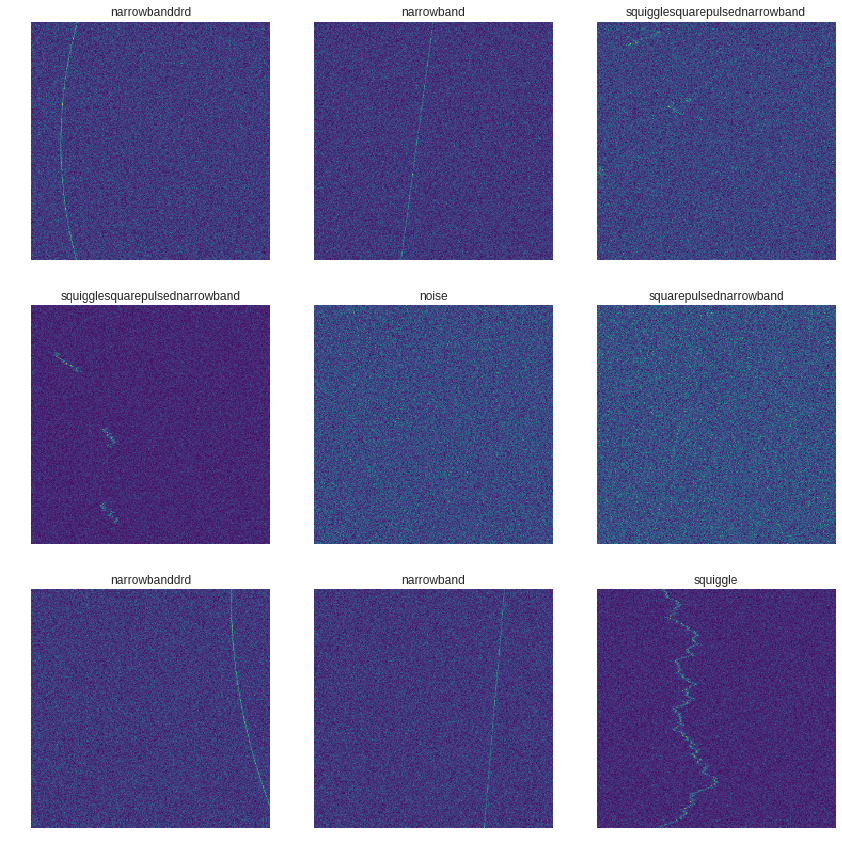

In [17]:
data.show_batch(rows=3)

In [0]:
arch = densenet161

In [0]:
learn = create_cnn(data, arch, metrics=[error_rate, accuracy])

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


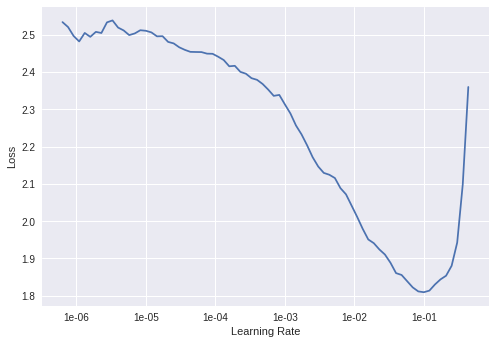

In [20]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.012867,0.684975,0.224286,0.775714
2,0.686661,0.451269,0.132857,0.867143
3,0.525519,0.416477,0.138571,0.861429
4,0.444029,0.354853,0.122857,0.877143
5,0.389794,0.325332,0.112857,0.887143


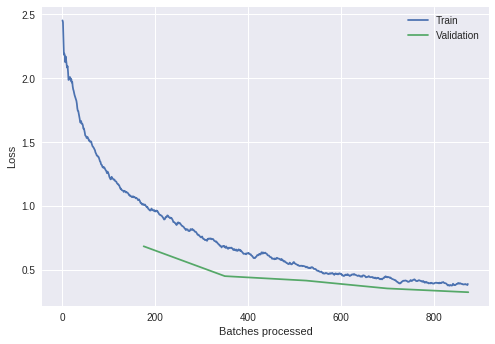

In [23]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


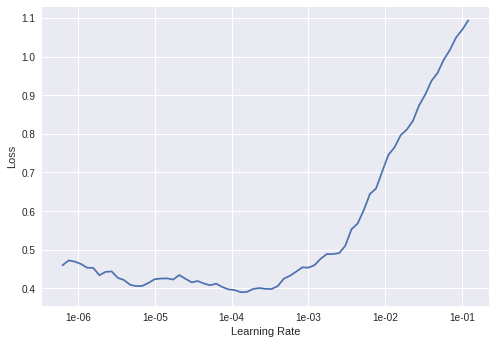

In [29]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr1 = 1e-6
lr2 = 1e-4

In [36]:
lr/10

0.001

In [40]:
learn.fit_one_cycle(5,slice(lr1, lr2))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.391633,0.318771,0.107143,0.892857
2,0.391039,0.318690,0.110000,0.890000
3,0.393146,0.328904,0.115714,0.884286
4,0.388538,0.322582,0.114286,0.885714
5,0.374702,0.321713,0.115714,0.884286


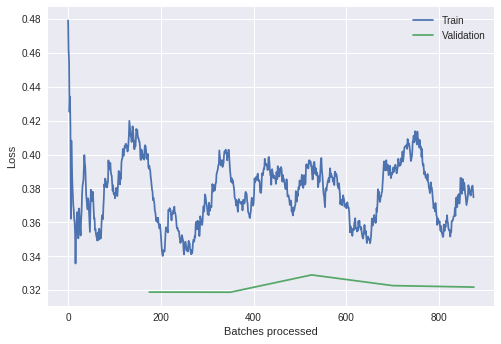

In [41]:
learn.recorder.plot_losses()

### Next
What we will try next is a larger image size (tuple) of the original image size, becuase of our memory constraints, we will have to decrease the batch size accordingly 

In [0]:
data = get_data(image_size=(384, 512), batch_size=16)

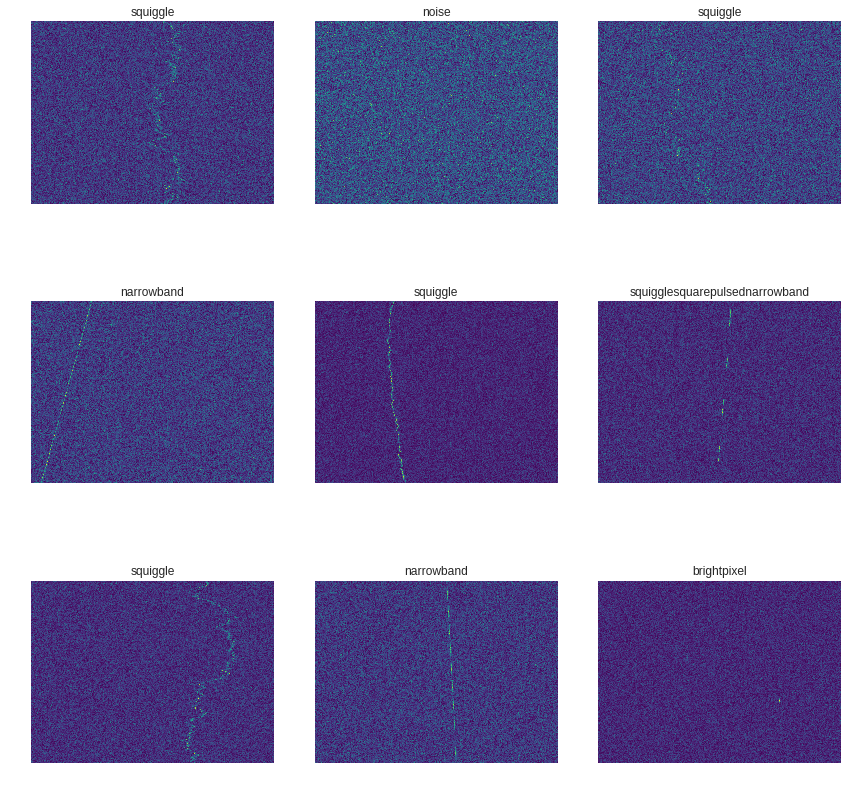

In [17]:
data.show_batch(rows=3)

In [0]:
arch = densenet169

In [19]:
learn = create_cnn(data, arch, metrics=[error_rate, accuracy])

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:00<00:00, 78207484.76it/s]


epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


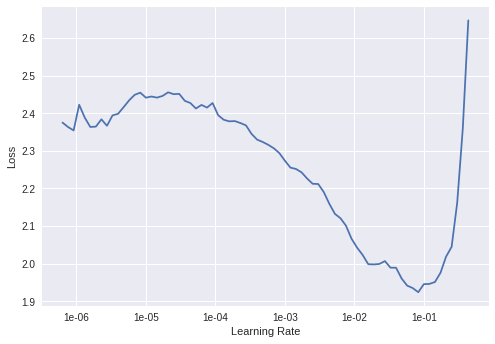

In [20]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [23]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.774304,0.713416,0.200000,0.800000
2,0.548647,0.354296,0.111429,0.888571
3,0.425334,0.284833,0.080000,0.920000
4,0.275667,0.252497,0.068571,0.931429
5,0.238925,0.247618,0.070000,0.930000


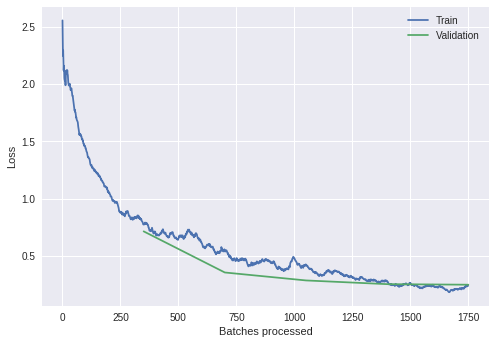

In [24]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-densenet169')

In [0]:
learn.load('stage-1-densenet169')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


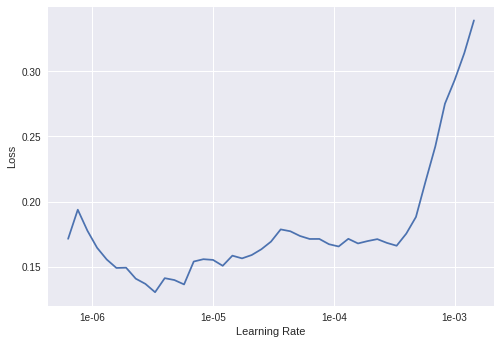

In [27]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr2 = 1e-5

In [33]:
learn.fit_one_cycle(4, slice(lr2, lr/10))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.215326,0.240772,0.071429,0.928571
2,0.196922,0.249703,0.071429,0.928571
3,0.169391,0.236336,0.067143,0.932857
4,0.123670,0.240536,0.065714,0.934286


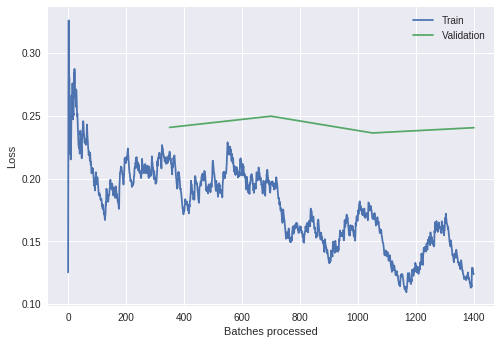

In [34]:
learn.recorder.plot_losses()

## Quick Conclusion
From running experiments, our **first experiment** we choose:
* image_size=224
* batch_size=32

which resulted in an accuracy of **88.4%**

For our **second experiment** we choose:
* image_size=(384,512) - default
* batch_size=16

which resulted in an accuracy of **93.4** which is about **~1%** off state of the art 

Though we had a high accuracy second round, our models seems to be overfitting just a bit, so what I would do if I were to continue with the **DenseNet169**, I would experiment with **Regularization** techniques
* Weight Decay
* Dropout
* Momentum 

To *generalize* the model much better. By doing so, our **accuracy** would increase.

## What we will attempt now
Given our **DenseNet169** Architecture performed relatively well, I would want to compose the same experiment with a larger model: **DenseNet201** and compare results

In [0]:
# smaller batchsize - our GPU memory can't handle a batchsize of 16 with these image sizes
data = get_data(image_size=(384, 512), batch_size=8)

In [0]:
arch = densenet201

In [15]:
learn = create_cnn(data, arch, metrics=[error_rate, accuracy])

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


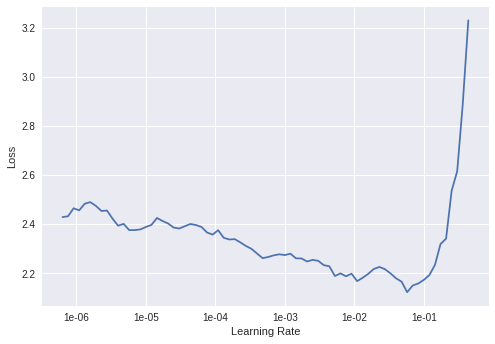

In [9]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# lr = 7e-3
lr = 1e-2

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.951362,0.496535,0.134286,0.865714
2,0.669245,1.035372,0.174286,0.825714
3,0.420613,0.734463,0.095714,0.904286
4,0.401179,0.259640,0.071429,0.928571
5,0.269858,0.224371,0.062857,0.937143


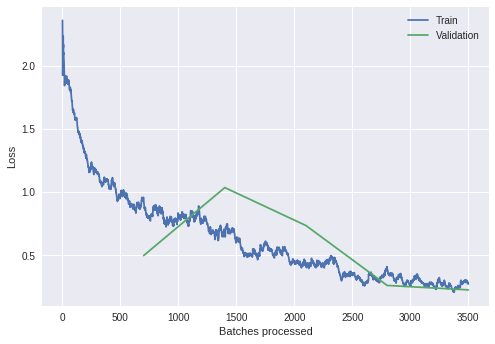

In [18]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-densenet201-B')

In [0]:
learn.load('stage-1-densenet201-B')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


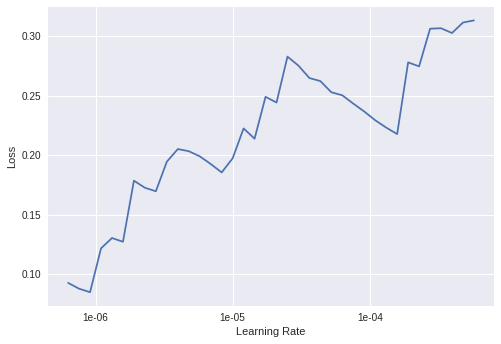

In [21]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr2 = 1e-6

In [32]:
lr/10

0.001

In [25]:
learn.fit_one_cycle(4, slice(lr2, lr/10))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.239103,0.428686,0.072857,0.927143
2,0.209105,0.390356,0.074286,0.925714
3,0.208558,0.233640,0.060000,0.940000
4,0.205043,0.316432,0.065714,0.934286


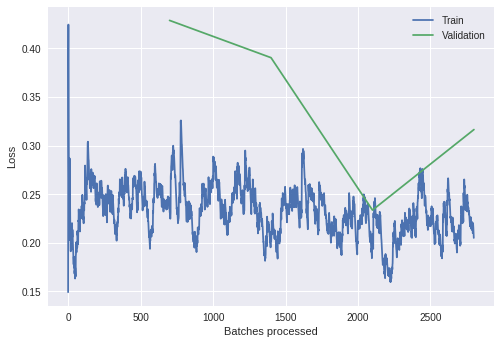

In [26]:
learn.recorder.plot_losses()

Last Attempt, we will train with a less aggressive learning rate

In [0]:
learn.load('stage-1-densenet201-B')

In [0]:
learn.unfreeze()

In [0]:
lr2 = 8e-7
lr1 = 1e-4

In [37]:
learn.fit_one_cycle(5, slice(lr2, lr1))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.249051,1.113178,0.068571,0.931429
2,0.251615,0.254965,0.061429,0.938571
3,0.242258,0.363642,0.065714,0.934286
4,0.211454,0.307333,0.071429,0.928571
5,0.209055,0.928753,0.064286,0.935714


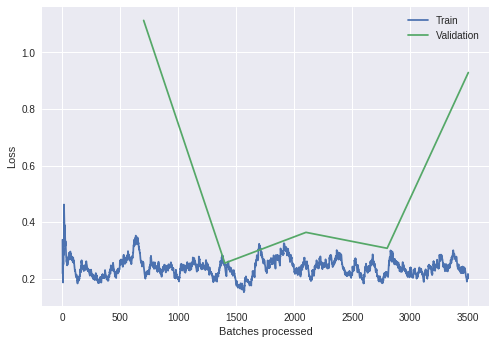

In [38]:
learn.recorder.plot_losses()

## Conclusions & Further Work
**our best: 93.7%** with it reaching **94%** accuracy, being only **0.6%** off the state of the art. 

What I would do to further increase our accuracy is search for fine-tuning parameters with our **DenseNet201** architecture.


This would allow us to train longer, preventing the model from overfitting by adding **regularization.** 


Doing the following:
* Weight Decay Search 
* Momentum Search
* Dropout Search 

I would also use a more memory intensive GPU and train on larger *batch sizes*. 